In [ ]:
import os
import time
import pandas as pd 
import numpy as np

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_curve, roc_auc_score)

# XGBoost (we will check for GPU support)
import xgboost as xgb

# For progress monitoring
from tqdm.auto import tqdm

# For plotting ROC curve
import matplotlib.pyplot as plt

print("All libraries imported successfully.")


All libraries imported successfully.


In [20]:
# Define the path to the preprocessed CSV data
preprocessed_data_path = r"C:\Users\prana\Desktop\AI Lab Project\preprocessed_amazon_reviews.csv"

# Load the dataset
df = pd.read_csv(preprocessed_data_path)
print("Original dataset shape:", df.shape)


Original dataset shape: (3962235, 18)


In [21]:
# Keep only the relevant columns for training
df = df[['clean_review', 'sentiment']]

# Drop rows with missing values in these columns only
df = df.dropna(subset=['clean_review', 'sentiment'])
print("Shape after dropping missing values:", df.shape)


Shape after dropping missing values: (3962104, 2)


In [22]:
sample_fraction = 0.1  # e.g., 10% of data
df_sampled = df.sample(frac=sample_fraction, random_state=42)
print("Sampled dataset shape:", df_sampled.shape)


Sampled dataset shape: (396210, 2)


In [23]:
X = df_sampled['clean_review']
y = df_sampled['sentiment']


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 316968
Testing samples: 79242


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)
print("TF‑IDF vectorization completed.")


NameError: name 'X_train' is not defined

In [26]:
# Random Forest (CPU)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# XGBoost: Try to use GPU; if not available, use CPU.
gpu_supported = True
try:
    # Try creating a dummy model with GPU parameters
    _ = xgb.XGBClassifier(tree_method='gpu_hist')
except xgb.core.XGBoostError:
    gpu_supported = False

if gpu_supported:
    xgb_clf = xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, 
                                random_state=42, verbosity=1,
                                tree_method='gpu_hist', predictor='gpu_predictor')
    print("XGBoost will use GPU acceleration.")
else:
    print("GPU support not available for XGBoost; using CPU version.")
    xgb_clf = xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, 
                                random_state=42, verbosity=1,
                                tree_method='auto', predictor='cpu_predictor')

# LinearSVC wrapped with CalibratedClassifierCV to obtain probabilities
svm_base = LinearSVC(max_iter=1000, random_state=42)
svm_calibrated = CalibratedClassifierCV(svm_base, cv=3)

# Store base models in a dictionary for easy iteration
base_models = {
    'Random Forest': rf_clf,
    'XGBoost': xgb_clf,
    'Calibrated SVM': svm_calibrated
}


XGBoost will use GPU acceleration.


In [28]:
import time
from tqdm.auto import tqdm

print("Training base models:")
for name, clf in tqdm(base_models.items(), desc="Base models", total=len(base_models)):
    print(f"\nStarting training for {name}...")
    start_time = time.time()
    try:
        clf.fit(X_train_vect, y_train)
    except Exception as e:
        print(f"Error training {name}: {e}")
    elapsed = time.time() - start_time
    print(f"{name} training completed in {elapsed/60:.2f} minutes.")
print("All base models trained.")


Training base models:


Base models:   0%|          | 0/3 [00:00<?, ?it/s]


Starting training for Random Forest...
Random Forest training completed in 18.80 minutes.

Starting training for XGBoost...
Error training XGBoost: [16:59:49] C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\common\common.h:174: XGBoost version not compiled with GPU support.
XGBoost training completed in 0.01 minutes.

Starting training for Calibrated SVM...


c:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Calibrated SVM training completed in 0.10 minutes.
All base models trained.


Ensemble Accuracy on test set: 94.50%

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74      9614
           1       0.95      0.99      0.97     69628

    accuracy                           0.95     79242
   macro avg       0.91      0.81      0.85     79242
weighted avg       0.94      0.95      0.94     79242


Confusion Matrix:
[[ 6129  3485]
 [  870 68758]]


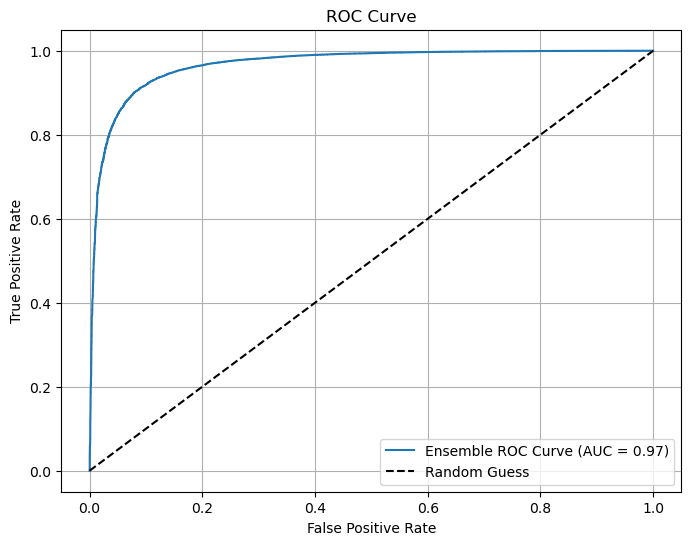

In [30]:
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted

def ensemble_predict_proba(X):
    prob_sum = np.zeros((X.shape[0], 2))  # for binary classification
    count = 0
    for name, clf in base_models.items():
        try:
            # Check if the model is fitted
            check_is_fitted(clf)
            prob = clf.predict_proba(X)
            prob_sum += prob
            count += 1
        except NotFittedError:
            print(f"Warning: Model '{name}' is not fitted; skipping it in ensemble predictions.")
    if count == 0:
        raise NotFittedError("None of the base models are fitted.")
    return prob_sum / count

def ensemble_predict(X):
    proba = ensemble_predict_proba(X)
    return np.argmax(proba, axis=1)

# Now get ensemble predictions on the test set
y_pred = ensemble_predict(X_test_vect)

# Evaluate the ensemble predictions
accuracy = accuracy_score(y_test, y_pred)
print("Ensemble Accuracy on test set: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Compute and plot the ROC AUC curve for the positive class (assuming class 1 is positive)
y_proba = ensemble_predict_proba(X_test_vect)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"Ensemble ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [31]:
import joblib

def save_ensemble_model(base_models, vectorizer, filename="ensemble_model.pkl"):
    """
    Save the ensemble model components (base models and vectorizer) to disk.
    
    Parameters:
        base_models (dict): A dictionary containing the base models.
        vectorizer (TfidfVectorizer): The fitted TF‑IDF vectorizer.
        filename (str): The output filename (default "ensemble_model.pkl").
    """
    ensemble_data = {
        "base_models": base_models,
        "vectorizer": vectorizer
    }
    joblib.dump(ensemble_data, filename)
    print(f"Ensemble model saved to {filename}")

# Example usage:
save_ensemble_model(base_models, vectorizer, "ensemble_model.pkl")


Ensemble model saved to ensemble_model.pkl


In [32]:
from IPython.display import FileLink
display(FileLink("ensemble_model.pkl"))


c:\Users\prana\Desktop\AI Lab Project\ensemble_model.pkl

In [3]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
import joblib
import numpy as np
from sklearn.exceptions import NotFittedError # type: ignore

# Load the saved ensemble model and vectorizer from the pkl file.
try:
    model_data = joblib.load("ensemble_model.pkl")
    base_models = model_data["base_models"]
    vectorizer = model_data["vectorizer"]
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading the model: {e}")
    exit()

def ensemble_predict_proba(X):
    """
    Compute the average predicted probabilities from all fitted base models.
    Models that are not fitted are skipped.
    """
    prob_sum = np.zeros((X.shape[0], 2))  # For binary classification (2 classes)
    count = 0
    for clf in base_models.values():
        try:
            prob_sum += clf.predict_proba(X)
            count += 1
        except NotFittedError:
            # Silently skip models that are not fitted.
            continue
        except Exception:
            continue
    if count == 0:
        raise ValueError("None of the models are fitted.")
    return prob_sum / count

def ensemble_predict(X):
    """
    Predict class labels based on the averaged predicted probabilities.
    """
    proba = ensemble_predict_proba(X)
    return np.argmax(proba, axis=1)

def classify_review(review):
    """
    Classify a new review using the saved ensemble model.
    
    Parameters:
        review (str): The input review text.
    
    Returns:
        str: Predicted sentiment ("Positive" or "Negative").
    """
    # Transform the input review using the saved TF-IDF vectorizer.
    review_vect = vectorizer.transform([review])
    # Get the ensemble prediction.
    predicted_class = ensemble_predict(review_vect)[0]
    # Map numeric prediction to human-readable label.
    class_mapping = {0: "Negative", 1: "Positive"}
    return class_mapping.get(predicted_class, "Unknown")

# Example usage: classify a user-entered review without retraining the model.
input_review = input("Enter a review: ")
prediction = classify_review(input_review)
print(f"Predicted Sentiment: {prediction}")


c:\Users\Shivansh\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Shivansh\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error loading the model: No module named 'xgboost'


NameError: name 'vectorizer' is not defined

: 